In [2]:
%pip install onnx onnxruntime 

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import TrainingArguments, Trainer
import torch
from transformers import AutoModelForSequenceClassification


# Load custom dataset from CSV
train_df = pd.read_csv("/kaggle/input/papandataset/train_clean.csv")
test_df = pd.read_csv("/kaggle/input/papandataset/test_clean.csv")
val_df = pd.read_csv("/kaggle/input/papandataset/val_clean.csv")

2024-05-05 20:09:17.295866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 20:09:17.295968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 20:09:17.574050: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [22]:
# Remove duplicates based on all columns
train_df.drop_duplicates(inplace=True)

In [23]:
train_df.shape

(43155, 29)

In [24]:
# #Load tokenizer and model
# model_name = 'microsoft/xtremedistil-l6-h384-uncased'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=28)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/xtremedistil-l6-h384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# 43 max else overfit
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=28)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# model_name = 'bert-base-uncased'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=28)


In [3]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# model_name = 'distilbert-base-uncased'

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=28)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:

# Tokenize function
class EmotionsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=64):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]["Clean_text"]
        labels = self.dataframe.iloc[idx][1:]  # Assuming labels start from the second column
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors='pt')
        labels = torch.tensor(labels.values.astype(float), dtype=torch.float)  # Convert labels to float
        # Adjust input to the format expected by the model
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_dataset = EmotionsDataset(train_df, tokenizer)
val_dataset = EmotionsDataset(val_df, tokenizer)
test_dataset = EmotionsDataset(test_df, tokenizer)



In [7]:
from transformers import Trainer
from transformers.trainer_callback import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions > 0.5  # Convert logits to binary predictions
  accuracy = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
  return {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1': f1
  }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,  # Set batch size to 16
    per_device_eval_batch_size=16,  # Set batch size to 16 for evaluation
    learning_rate=5e-5,  # Set learning rate to 5e-5
    logging_dir='./logs',
    evaluation_strategy='epoch',  # Evaluate every epoch
    save_strategy='epoch',  # Save model every epoch
    save_total_limit=1,  # Only keep one checkpoint
    load_best_model_at_end=True  # Ensure that the best model is loaded at the end
)

# No learning rate scheduler is included in this code

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Optional: Early stopping callback
)


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [8]:

trainer.train()


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.104200,0.090783,0.313491,0.626426,0.321630,0.391103
2,0.085600,0.085140,0.347033,0.723664,0.350940,0.436259
3,0.076400,0.084929,0.375046,0.717950,0.387461,0.472194
4,0.068600,0.087926,0.408035,0.687881,0.433072,0.506237
5,0.060900,0.091630,0.430704,0.660045,0.457524,0.527346
6,0.051100,0.095770,0.447291,0.649801,0.474295,0.534902


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to 

TrainOutput(global_step=8142, training_loss=0.07697568774896826, metrics={'train_runtime': 2647.49, 'train_samples_per_second': 163.967, 'train_steps_per_second': 5.126, 'total_flos': 8568237917583360.0, 'train_loss': 0.07697568774896826, 'epoch': 6.0})

In [ ]:
# Evaluate the model
eval_result = trainer.evaluate(eval_dataset=test_dataset)

# Print evaluation result
print("Evaluation result:", eval_result)

# Check if the model is overfitting
train_loss = trainer.evaluate(train_dataset)['eval_loss']  # Accessing 'eval_loss' instead of 'loss'
val_loss = eval_result['eval_loss']  # Accessing 'eval_loss' instead of 'loss'

if val_loss < train_loss:
    print("Validation loss ({}) is less than training loss ({}), indicating potential overfitting.".format(val_loss, train_loss))
else:
    print("Validation loss ({}) is greater than or equal to training loss ({}), indicating no overfitting.".format(val_loss, train_loss))


In [9]:
import os

# # Create a directory to save the ONNX model
output_dir = "/kaggle/working/mymodel"

os.makedirs(output_dir, exist_ok=True)


onnx_path = os.path.join(output_dir, "model.onnx")

# Convert the PyTorch model to ONNX format
dummy_input = (torch.zeros(1, 64).long().to("cuda:0"), torch.zeros(1, 64).long().to("cuda:0"))  # Ensure input_ids and attention_mask tensors are on the same device as the model
input_names = ["input_ids", "attention_mask"]  # Specify input names
output_names = ["output"]

torch.onnx.export(model, dummy_input, onnx_path, input_names=input_names, output_names=output_names)


In [21]:
from IPython.display import HTML

# Provide the path to your model file
model_path = "/kaggle/working/mymodel/model.onnx"

# Generate download link manually
html = '<a href="{0}" target="_blank">Click here to download model</a>'.format(model_path)
HTML(html)


In [19]:
kaggle kernels output -p /local/path/to/download


SyntaxError: invalid syntax (44603412.py, line 1)

In [11]:
# Load the ONNX model
import onnxruntime

ort_session = onnxruntime.InferenceSession(onnx_path)

# Define the emotion labels
emotion_labels = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral'
]

# Define the test sentence
test_sentence = "may be you could help me archieve it"


# Tokenize the test sentence with max_length=64 and padding=True
inputs = tokenizer(test_sentence, return_tensors="pt", padding="max_length", truncation=True, max_length=64)


# Prepare inputs as a dictionary
inputs_onnx = {
    "input_ids": inputs["input_ids"].numpy(),
    "attention_mask": inputs["attention_mask"].numpy()
}

# Perform inference using ONNX
ort_inputs = {key: inputs_onnx[key] for key in input_names}
ort_outs = ort_session.run(None, ort_inputs)

# Get the predicted label
predicted_label_index = ort_outs[0].argmax()
predicted_emotion = emotion_labels[predicted_label_index]

# Print the predicted emotion
print("Predicted emotion:", predicted_emotion)


Predicted emotion: optimism


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

true_labels = []
predicted_labels = []

test_dataloader = DataLoader(test_dataset, batch_size=1)  # Set batch_size=1 to iterate over individual samples

for batch in test_dataloader:
    batch = {key: value.to("cuda:0") for key, value in batch.items()}
    
    ort_inputs = {key: batch[key].cpu().numpy() for key in input_names}
    ort_outs = ort_session.run(None, ort_inputs)
    
    predicted_label_indices = ort_outs[0].argmax(axis=1)
    predicted_batch_emotions = [emotion_labels[index] for index in predicted_label_indices]
    
    true_batch_labels = [emotion_labels[index] for index in batch['labels'].cpu().numpy().argmax(axis=1)]
    
    true_labels.extend(true_batch_labels)
    predicted_labels.extend(predicted_batch_emotions)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=emotion_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report
class_report = classification_report(true_labels, predicted_labels, labels=emotion_labels)

# Print classification report
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[338  12   0   2   5   4   1   4   0   3   3   0   0   5   2  32   0  14
   34   0  11   0   0   0   0   2   7  25]
 [  5 218   0   1   2   0   1   1   0   0   1   0   0   0   0  10   0   2
    3   0   0   0   1   0   0   0   1   6]
 [  5   2  58  39   2   4   1  13   1   1  18  11   0   0   1   3   0   0
    4   0   0   0   1   0   2   1   3  27]
 [  5   4  11  76  11   4   0  14   1  10  29  10   1   0   6   2   0   0
    4   0   4   0   1   0   2   4   4  83]
 [ 26   5   1   3 113  14   2   3   0   5  11   0   0   4   1   6   0   6
   12   0  12   0   0   0   2   1   3  88]
 [  3   1   1   1   7  50   0   0   1   2   2   0   0   1   1   4   0   5
    7   0  10   0   0   0   1   0   0  17]
 [  2   2   0   1   3   1  60  39   0   1   6   0   0   0   0   2   0   1
    1   0   0   0   0   0   2   0   3  15]
 [  7   1   2   0   2   5   9 144   0   1   0   0   1   3   2   2   0   1
    5   0   3   0   0   0   2   2   7  34]
 [  3   1   1   1   3   2   0   2  26   1   0 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5653215404459185


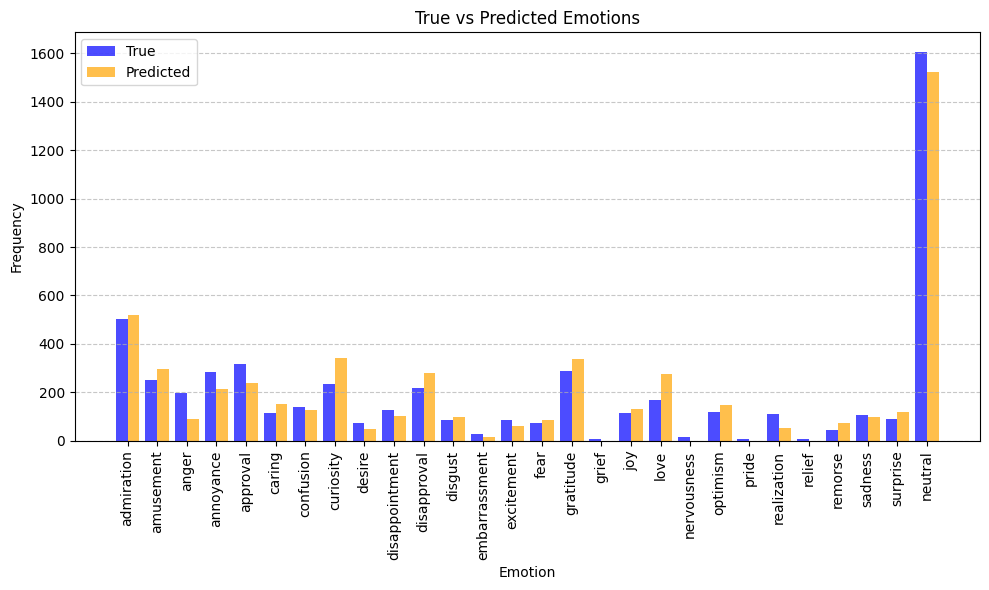

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Print accuracy
print("Accuracy:", accuracy)

# Plot graphs of predictions
def plot_predictions(true_labels, predicted_labels, emotion_labels):
    # Convert labels to numeric indices
    true_indices = np.array([emotion_labels.index(label) for label in true_labels])
    predicted_indices = np.array([emotion_labels.index(label) for label in predicted_labels])

    # Plot
    plt.figure(figsize=(10, 6))
    plt.hist([true_indices, predicted_indices], bins=np.arange(len(emotion_labels) + 1) - 0.5, label=['True', 'Predicted'], color=['blue', 'orange'], alpha=0.7)
    plt.xticks(range(len(emotion_labels)), emotion_labels, rotation=90)
    plt.xlabel('Emotion')
    plt.ylabel('Frequency')
    plt.title('True vs Predicted Emotions')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot predictions
plot_predictions(true_labels, predicted_labels, emotion_labels)
